In [123]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn.functional as F

from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Toy MTL

"Is it a hotdog? Or is it not a hotdog"

Training sets will be identical for each task but labels will be binary classes for whether an example is or is not a particular digit. e.g., task 1 is about identifying digits are a 0 or not. task 2 is about identifying digits are a 1 or not.

In [2]:
mnist_train = torchvision.datasets.MNIST('/tmp/mnist', download=True, train=True)
mnist_test = torchvision.datasets.MNIST('/tmp/mnist', download=True, train=False)

In [3]:
x_train = mnist_train.data
y_train = mnist_train.targets

x_test = mnist_test.data
y_test = mnist_test.targets

In [4]:
t0_digit = 2
t1_digit = 5

# NOTE: x_train, x_test remains the same for both tasks

y_t0_train = torch.where(y_train == t0_digit, 1, 0)
y_t0_test = torch.where(y_test == t0_digit, 1, 0)
y_t1_train = torch.where(y_train == t1_digit, 1, 0)
y_t1_test = torch.where(y_test == t1_digit, 1, 0)

In [5]:
def accuracy(y_hat, y):
    assert y_hat.shape == y.shape
    n_classes = y_hat.shape[-1]
    y_hat = y_hat.view(-1, n_classes)
    y = y.view(-1, n_classes)
    n_correct = torch.sum(y_hat == y)
    return n_correct / y_hat.numel()

In [6]:
class MultiTaskDataset:
    def __init__(self, x, t0_y, t1_y):
        self.x = x
        self.t0_y = t0_y
        self.t1_y = t1_y
        
    def __getitem__(self, idx):
        return self.x[idx] / 255., self.t0_y[idx], self.t1_y[idx]
            
    def __len__(self):
        return len(self.x)

In [7]:
class TaskFiLM(nn.Module):
    def __init__(self, channels, n_tasks, embedding_dim=512):
        super().__init__()
        self.embed = nn.Embedding(n_tasks, embedding_dim)
        self.scale = nn.Linear(embedding_dim, channels)
        self.shift = nn.Linear(embedding_dim, channels)
        # TODO: initialize this layer so that scale is 1 and shift is 0
        
    def forward(self, task_idx):
        embedding = self.embed(task_idx)
        return self.scale(embedding), self.shift(embedding)
        

class FeaturewiseTransform(nn.Module):
    def forward(self, x, scale, shift):
        return scale * x + shift
                 
        
class TaskActSoftGate(nn.Module):
    def __init__(self, channels, n_tasks, embedding_dim=512):
        super().__init__()
        self.embed = nn.Embedding(n_tasks, embedding_dim)
        self.gate = nn.Linear(embedding_dim, channels)
    
    def forward(self, task_idx):
        embedding = self.embed(task_idx)
        x = self.gate(embedding)
        return torch.sigmoid(x)

    
class TaskAttnGate(nn.Module):
    def __init__(self, in_c, out_c, n_tasks, embedding_dim=512):
        super().__init__()
        self.n_tasks = n_tasks
        self.out_channels = out_c
        self.embed = nn.Embedding(n_tasks, embedding_dim)
        self.gate = nn.Linear(embedding_dim, n_tasks)
        self.attn_heads = nn.Linear(in_c, n_tasks * out_c)
        
    def forward(self, x, task_idx):
        task = self.embed(task_idx)
        weights = nn.functional.softmax(self.gate(task), dim=-1)
        values = self.attn_heads(x).view(-1, self.n_tasks, self.out_channels)
        a = torch.sum(weights[..., None] * values, dim=1)
        return a


class MTL(nn.Module):
    """Generic multi-task learner."""

    def __init__(self, shared=True):
        super().__init__()
        
        self.shared = shared
        
        self.backbone = nn.Sequential(
            nn.Linear(28 * 28, 32),
            nn.ReLU(),
        )
        
        if not self.shared:
            self.backbone2 = nn.Sequential(
                nn.Linear(28 * 28, 32),
                nn.ReLU(),
            )
                
        self.t0_head = nn.Linear(32, 1)
        self.t1_head = nn.Linear(32, 1)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        t0_logits = self.t0_head(self.backbone(x))
        
        if not self.shared:
            t1_logits = self.t1_head(self.backbone2(x))
        else:
            t1_logits = self.t1_head(self.backbone(x))
        
        return t0_logits, t1_logits
    
    def loss(self, x, t0_y, t1_y, t0_lambda=1.0, t1_lambda=1.0):
        t0_logits, t1_logits = self.forward(x)
        t0_logits = t0_logits.view(-1,)
        t1_logits = t1_logits.view(-1,)
        
        t0_loss = nn.functional.binary_cross_entropy_with_logits(t0_logits, t0_y)
        t1_loss = nn.functional.binary_cross_entropy_with_logits(t1_logits, t1_y)
        total_loss = t0_lambda * t0_loss + t1_lambda * t1_loss
        losses = {
            'loss/total': total_loss,
            'loss/t0': t0_loss,
            'loss/t1': t1_loss,
        }
        return losses
    
    
class FiLMTL(MTL):
    """Task-conditioned multi-task learner with FiLM."""
    
    def __init__(self, n_tasks):
        super().__init__()
   
        self.film_gen = TaskFiLM(32, n_tasks=n_tasks, embedding_dim=64)
        
        # backbone
        self.in_proj = nn.Linear(28 * 28, 32)
        self.transform = FeaturewiseTransform()
        self.relu = nn.ReLU()
        
        # heads
        self.t0_head = nn.Linear(32, 1)
        self.t1_head = nn.Linear(32, 1)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)

        t0_scale, t0_shift = self.film_gen(torch.zeros(x.shape[0], dtype=torch.long, device=x.device))
        t1_scale, t1_shift = self.film_gen(torch.ones(x.shape[0], dtype=torch.long, device=x.device))
        
        x = self.in_proj(x)
        
        t0_x = self.transform(x, t0_scale, t0_shift)
        t0_x = self.relu(t0_x)
        
        t1_x = self.transform(x, t1_scale, t1_shift)
        t1_x = self.relu(t1_x)
        
        t0_logits = self.t0_head(t0_x)
        t1_logits = self.t1_head(t1_x)
        return t0_logits, t1_logits
    

class FiLMTL(MTL):
    """Task-conditioned multi-task learner with FiLM."""
    
    def __init__(self, n_tasks):
        super().__init__()
   
        self.film_gen = TaskFiLM(32, n_tasks=n_tasks, embedding_dim=64)
        
        # backbone
        self.in_proj = nn.Linear(28 * 28, 32)
        self.transform = FeaturewiseTransform()
        self.relu = nn.ReLU()
        
        # heads
        self.t0_head = nn.Linear(32, 1)
        self.t1_head = nn.Linear(32, 1)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)

        t0_scale, t0_shift = self.film_gen(torch.zeros(x.shape[0], dtype=torch.long, device=x.device))
        t1_scale, t1_shift = self.film_gen(torch.ones(x.shape[0], dtype=torch.long, device=x.device))
        
        x = self.in_proj(x)
        
        t0_x = self.transform(x, t0_scale, t0_shift)
        t0_x = self.relu(t0_x)
        
        t1_x = self.transform(x, t1_scale, t1_shift)
        t1_x = self.relu(t1_x)
        
        t0_logits = self.t0_head(t0_x)
        t1_logits = self.t1_head(t1_x)
        return t0_logits, t1_logits
    

class SoftActGateMTL(MTL):
    
    def __init__(self, n_tasks):
        super().__init__()
        
        self.soft_gate = TaskActSoftGate(32, n_tasks=n_tasks, embedding_dim=64)
        
        # backbone
        self.in_proj = nn.Linear(28 * 28, 32)
        self.relu = nn.ReLU()
        
        # heads
        self.t0_head = nn.Linear(32, 1)
        self.t1_head = nn.Linear(32, 1)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        
        t0_gate = self.soft_gate(torch.zeros(x.shape[0], dtype=torch.long, device=x.device))
        t1_gate = self.soft_gate(torch.ones(x.shape[0], dtype=torch.long, device=x.device))
                
        x = self.in_proj(x)

        t0_x = t0_gate * x
        t0_x = self.relu(t0_x)
        
        t1_x = t1_gate * x
        t1_x = self.relu(t1_x)
        
        t0_logits = self.t0_head(t0_x)
        t1_logits = self.t1_head(t1_x)
        return t0_logits, t1_logits
    

class AttnGateMTL(MTL):
    
    def __init__(self, n_tasks):
        super().__init__()
        
        
        # backbone
        self.attn_gate = TaskAttnGate(28 * 28, 32, n_tasks=n_tasks, embedding_dim=64)

        # self.in_proj = nn.Linear(28 * 28, 32)
        self.relu = nn.ReLU()
        
        # heads
        self.t0_head = nn.Linear(32, 1)
        self.t1_head = nn.Linear(32, 1)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        
        t0 = torch.zeros(x.shape[0], dtype=torch.long, device=x.device)
        t1 = torch.ones(x.shape[0], dtype=torch.long, device=x.device)
        
        t0_x = self.attn_gate(x, t0)
        t1_x = self.attn_gate(x, t1)

        t0_x = self.relu(t0_x)
        t1_x = self.relu(t1_x)
        
        t0_logits = self.t0_head(t0_x)
        t1_logits = self.t1_head(t1_x)
        return t0_logits, t1_logits

In [8]:
def train_mtl(
    *, 
    model, 
    train_loader, 
    val_loader, 
    lr=1e-3, 
    epochs=5, 
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_metrics = {'loss/total': [], 
                     'loss/t0': [], 
                     'loss/t1': [],
                     'acc/t0': [],
                     'acc/t1': [],
                    }
    val_metrics = {'loss/total': [], 
                     'loss/t0': [], 
                     'loss/t1': [],
                     'acc/t0': [],
                     'acc/t1': [],
                    }

    for epoch in range(epochs):
        model.train()
        for batch in tqdm(train_loader, total=len(train_loader)):    
            im, t0_labels, t1_labels = batch
            
            loss = model.loss(im, t0_labels.float(), t1_labels.float())
            total_loss = loss['loss/total']

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # loss metrics
            for k in train_metrics.keys():
                if k in loss:
                    train_metrics[k].append(loss[k].item())

            # accuracy metrics
            t0_logits, t1_logits = model.forward(im)
            t0_pred = nn.functional.sigmoid(t0_logits) > 0.5
            t1_pred = nn.functional.sigmoid(t1_logits) > 0.5
            train_metrics['acc/t0'].append(accuracy(t0_pred[:, 0], t0_labels.bool()))
            train_metrics['acc/t1'].append(accuracy(t1_pred[:, 0], t1_labels.bool()))


        t0_val_loss = 0
        t1_val_loss = 0
        t0_val_acc = 0
        t1_val_acc = 0
        val_count = 0

        model.eval()
        for batch in val_loader:
            im, t0_labels, t1_labels = batch
            val_loss = model.loss(im, t0_labels.float(), t1_labels.float())

            val_count += len(im)        
            t0_val_loss += val_loss['loss/t0'].item() * len(im)
            t1_val_loss += val_loss['loss/t1'].item() * len(im)

            # accuracy metrics
            t0_logits, t1_logits = model.forward(im)
            t0_pred = torch.sigmoid(t0_logits) > 0.5
            t1_pred = torch.sigmoid(t1_logits) > 0.5
            t0_val_acc += accuracy(t0_pred[:, 0], t0_labels.bool()).item() * len(im)
            t1_val_acc += accuracy(t1_pred[:, 0], t1_labels.bool()).item() * len(im)

        val_metrics['loss/t0'].append(t0_val_loss / val_count)
        val_metrics['loss/t1'].append(t1_val_loss / val_count)
        val_metrics['acc/t0'].append(t0_val_acc / val_count)
        val_metrics['acc/t1'].append(t1_val_acc / val_count)
    
    return train_metrics, val_metrics

In [9]:
EPOCHS = 10
LR = 3e-4
BATCH_SIZE = 256

train_ds = MultiTaskDataset(x_train, y_t0_train, y_t1_train)
val_ds = MultiTaskDataset(x_test, y_t0_test, y_t1_test)
train_iter = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_iter = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)

In [30]:
_, shared_metrics = train_mtl(
    model=MTL(shared=True),
    train_loader=train_iter, 
    val_loader=val_iter,
    lr=LR, 
    epochs=EPOCHS,
)

Parameter containing:
tensor([[-0.0209,  0.0147, -0.0219,  ..., -0.0305, -0.0276, -0.0209],
        [ 0.0229,  0.0349, -0.0009,  ...,  0.0300,  0.0322,  0.0252],
        [-0.0139,  0.0290,  0.0191,  ...,  0.0246,  0.0122,  0.0338],
        ...,
        [ 0.0108, -0.0187,  0.0195,  ...,  0.0098,  0.0317,  0.0021],
        [-0.0118,  0.0089, -0.0237,  ..., -0.0203,  0.0072,  0.0219],
        [-0.0089, -0.0201, -0.0220,  ...,  0.0163,  0.0131, -0.0326]],
       requires_grad=True)


100%|███████████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 328.12it/s]


In [462]:
_, separate_metrics = train_mtl(
    model=MTL(shared=False),
    train_loader=train_iter, 
    val_loader=val_iter,
    lr=LR, 
    epochs=EPOCHS,
)

100%|███████████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 305.60it/s]


In [463]:
film_train, film_metrics = train_mtl(
    model=FiLMTL(n_tasks=2),
    train_loader=train_iter, 
    val_loader=val_iter,
    lr=LR, 
    epochs=EPOCHS,
)

100%|███████████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 290.62it/s]


In [464]:
_, sag_metrics = train_mtl(
    model=SoftActGateMTL(n_tasks=2),
    train_loader=train_iter, 
    val_loader=val_iter,
    lr=LR, 
    epochs=EPOCHS,
)

100%|███████████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 299.84it/s]


In [465]:
atg_train, atg_metrics = train_mtl(
    model=AttnGateMTL(n_tasks=2),
    train_loader=train_iter, 
    val_loader=val_iter,
    lr=LR, 
    epochs=EPOCHS,
)

100%|███████████████████████████████████████████████████████████████████████████████████| 235/235 [00:00<00:00, 242.86it/s]


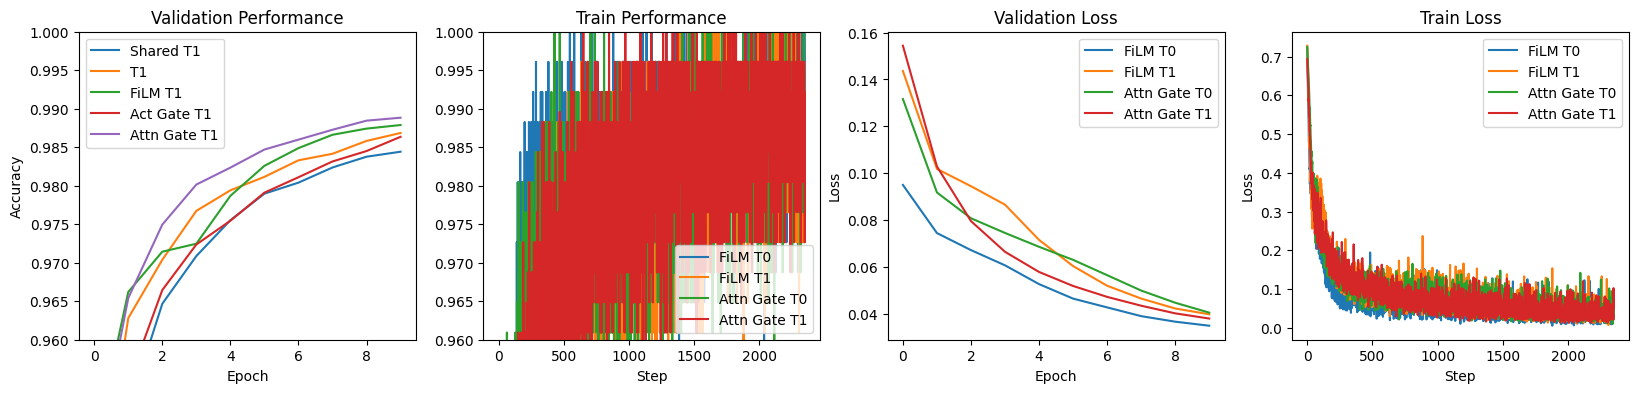

In [471]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
ax = axes[0]
ax.set_ylim([.96, 1])
ax.set_title('Validation Performance')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
# ax.plot(shared_metrics['acc/t0'], label='Shared T0')
ax.plot(shared_metrics['acc/t1'], label='Shared T1')
# ax.plot(separate_metrics['acc/t0'], label='T0')
ax.plot(separate_metrics['acc/t1'], label='T1')
# ax.plot(film_metrics['acc/t0'], label='FiLM T0')
ax.plot(film_metrics['acc/t1'], label='FiLM T1')
# ax.plot(sag_metrics['acc/t0'], label='Act Gate T0')
ax.plot(sag_metrics['acc/t1'], label='Act Gate T1')
# ax.plot(atg_metrics['acc/t0'], label='Attn Gate T0')
ax.plot(atg_metrics['acc/t1'], label='Attn Gate T1')
ax.legend()

tax = axes[1]
tax.set_ylim([.96, 1])
tax.set_title('Train Performance')
tax.set_xlabel('Step')
# tax.set_ylabel('Accuracy')
# tax.plot(shared_metrics['acc/t0'], label='Shared T0')
# tax.plot(shared_metrics['acc/t1'], label='Shared T1')
# tax.plot(separate_metrics['acc/t0'], label='T0')
# tax.plot(separate_metrics['acc/t1'], label='T1')
tax.plot(film_train['acc/t0'], label='FiLM T0')
tax.plot(film_train['acc/t1'], label='FiLM T1')
# tax.plot(sag_metrics['acc/t0'], label='Act Gate T0')
# tax.plot(sag_metrics['acc/t1'], label='Act Gate T1')
tax.plot(atg_train['acc/t0'], label='Attn Gate T0')
tax.plot(atg_train['acc/t1'], label='Attn Gate T1')
tax.legend()

lax = axes[2]
# lax.set_ylim([.95, .99])
lax.set_title('Validation Loss')
lax.set_xlabel('Epoch')
lax.set_ylabel('Loss')
# lax.plot(shared_metrics['acc/t0'], label='Shared T0')
# lax.plot(shared_metrics['acc/t1'], label='Shared T1')
# lax.plot(separate_metrics['acc/t0'], label='T0')
# lax.plot(separate_metrics['acc/t1'], label='T1')
lax.plot(film_metrics['loss/t0'], label='FiLM T0')
lax.plot(film_metrics['loss/t1'], label='FiLM T1')
# lax.plot(sag_metrics['acc/t0'], label='Act Gate T0')
# lax.plot(sag_metrics['acc/t1'], label='Act Gate T1')
lax.plot(atg_metrics['loss/t0'], label='Attn Gate T0')
lax.plot(atg_metrics['loss/t1'], label='Attn Gate T1')
lax.legend()

vax = axes[3]
vax.set_title('Train Loss')
vax.set_xlabel('Step')
vax.set_ylabel('Loss')
# vax.plot(shared_metrics['acc/t0'], label='Shared T0')
# vax.plot(shared_metrics['acc/t1'], label='Shared T1')
# vax.plot(separate_metrics['acc/t0'], label='T0')
# vax.plot(separate_metrics['acc/t1'], label='T1')
vax.plot(film_train['loss/t0'], label='FiLM T0')
vax.plot(film_train['loss/t1'], label='FiLM T1')
# vax.plot(sag_metrics['acc/t0'], label='Act Gate T0')
# vax.plot(sag_metrics['acc/t1'], label='Act Gate T1')
vax.plot(atg_train['loss/t0'], label='Attn Gate T0')
vax.plot(atg_train['loss/t1'], label='Attn Gate T1')
vax.legend()

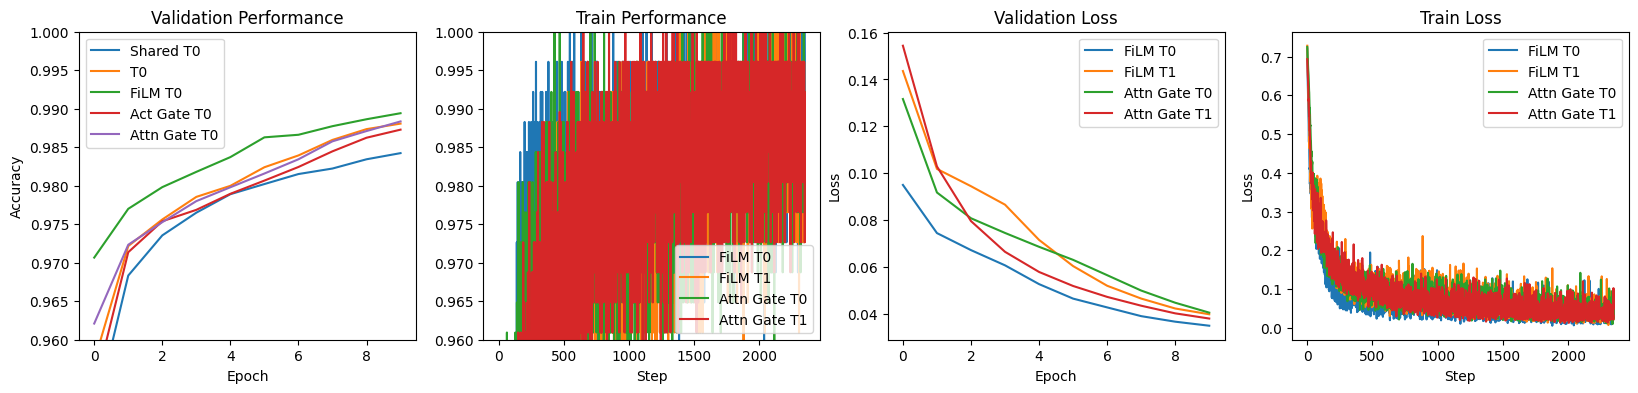

In [472]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
ax = axes[0]
ax.set_ylim([.96, 1])
ax.set_title('Validation Performance')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot(shared_metrics['acc/t0'], label='Shared T0')
# ax.plot(shared_metrics['acc/t1'], label='Shared T1')
ax.plot(separate_metrics['acc/t0'], label='T0')
# ax.plot(separate_metrics['acc/t1'], label='T1')
ax.plot(film_metrics['acc/t0'], label='FiLM T0')
# ax.plot(film_metrics['acc/t1'], label='FiLM T1')
ax.plot(sag_metrics['acc/t0'], label='Act Gate T0')
# ax.plot(sag_metrics['acc/t1'], label='Act Gate T1')
ax.plot(atg_metrics['acc/t0'], label='Attn Gate T0')
# ax.plot(atg_metrics['acc/t1'], label='Attn Gate T1')
ax.legend()

tax = axes[1]
tax.set_ylim([.96, 1])
tax.set_title('Train Performance')
tax.set_xlabel('Step')
# tax.set_ylabel('Accuracy')
# tax.plot(shared_metrics['acc/t0'], label='Shared T0')
# tax.plot(shared_metrics['acc/t1'], label='Shared T1')
# tax.plot(separate_metrics['acc/t0'], label='T0')
# tax.plot(separate_metrics['acc/t1'], label='T1')
tax.plot(film_train['acc/t0'], label='FiLM T0')
tax.plot(film_train['acc/t1'], label='FiLM T1')
# tax.plot(sag_metrics['acc/t0'], label='Act Gate T0')
# tax.plot(sag_metrics['acc/t1'], label='Act Gate T1')
tax.plot(atg_train['acc/t0'], label='Attn Gate T0')
tax.plot(atg_train['acc/t1'], label='Attn Gate T1')
tax.legend()

lax = axes[2]
# lax.set_ylim([.95, .99])
lax.set_title('Validation Loss')
lax.set_xlabel('Epoch')
lax.set_ylabel('Loss')
# lax.plot(shared_metrics['acc/t0'], label='Shared T0')
# lax.plot(shared_metrics['acc/t1'], label='Shared T1')
# lax.plot(separate_metrics['acc/t0'], label='T0')
# lax.plot(separate_metrics['acc/t1'], label='T1')
lax.plot(film_metrics['loss/t0'], label='FiLM T0')
lax.plot(film_metrics['loss/t1'], label='FiLM T1')
# lax.plot(sag_metrics['acc/t0'], label='Act Gate T0')
# lax.plot(sag_metrics['acc/t1'], label='Act Gate T1')
lax.plot(atg_metrics['loss/t0'], label='Attn Gate T0')
lax.plot(atg_metrics['loss/t1'], label='Attn Gate T1')
lax.legend()

vax = axes[3]
vax.set_title('Train Loss')
vax.set_xlabel('Step')
vax.set_ylabel('Loss')
# vax.plot(shared_metrics['acc/t0'], label='Shared T0')
# vax.plot(shared_metrics['acc/t1'], label='Shared T1')
# vax.plot(separate_metrics['acc/t0'], label='T0')
# vax.plot(separate_metrics['acc/t1'], label='T1')
vax.plot(film_train['loss/t0'], label='FiLM T0')
vax.plot(film_train['loss/t1'], label='FiLM T1')
# vax.plot(sag_metrics['acc/t0'], label='Act Gate T0')
# vax.plot(sag_metrics['acc/t1'], label='Act Gate T1')
vax.plot(atg_train['loss/t0'], label='Attn Gate T0')
vax.plot(atg_train['loss/t1'], label='Attn Gate T1')
vax.legend()

### Gradient Alignment

In [10]:
mnist_train = torchvision.datasets.MNIST('/tmp/mnist', download=True, train=True)
mnist_test = torchvision.datasets.MNIST('/tmp/mnist', download=True, train=False)

In [11]:
x_train = mnist_train.data
y_train = mnist_train.targets

x_test = mnist_test.data
y_test = mnist_test.targets

In [277]:
t0_digit = 5
t1_digit = 2

# NOTE: x_train, x_test remains the same for both tasks

y_t0_train = torch.where(y_train == t0_digit, 1, 0)
y_t0_test = torch.where(y_test == t0_digit, 1, 0)
y_t1_train = torch.where(y_train == t1_digit, 1, 0)
y_t1_test = torch.where(y_test == t1_digit, 1, 0)

In [360]:
class Shareable(nn.Module):
    """Make a layer shareable!"""
    
    def __init__(self, mdl, shared=False):
        super().__init__()
        
        self.mdl = mdl
        # if shared
        

class SharedMTL(nn.Module):
    """Shared backbone multi-task learner."""

    def __init__(self):
        super().__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
        )
        
        self.t0_head = nn.Linear(256, 1)
        self.t1_head = nn.Linear(256, 1)
    
    def forward(self, x):
        # x = x.view(-1, 28 * 28)
        x = x.view(-1, 1, 28, 28)
        x = self.backbone(x)
        x = x.view(x.shape[0], -1) # flatten
        t0_logits = self.t0_head(x)
        t1_logits = self.t1_head(x)
        return t0_logits, t1_logits
    
    def loss(self, x, t0_y, t1_y, t0_lambda=1.0, t1_lambda=1.0):
        t0_logits, t1_logits = self.forward(x)
        t0_logits = t0_logits.view(-1,)
        t1_logits = t1_logits.view(-1,)
        
        t0_loss = nn.functional.binary_cross_entropy_with_logits(t0_logits, t0_y)
        t1_loss = nn.functional.binary_cross_entropy_with_logits(t1_logits, t1_y)
        total_loss = t0_lambda * t0_loss + t1_lambda * t1_loss
        losses = {
            'loss/total': total_loss,
            'loss/t0': t0_loss,
            'loss/t1': t1_loss,
        }
        return losses
    
    
class SeparateMTL(nn.Module):
    """Fully-separated backbone multi-task learner."""

    def __init__(self):
        super().__init__()

        self.t0_backbone = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
        )
        
        self.t1_backbone = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
        )
        
        self.t0_head = nn.Linear(256, 1)
        self.t1_head = nn.Linear(256, 1)
    
    def forward(self, x):
        # x = x.view(-1, 28 * 28)
        x = x.view(-1, 1, 28, 28)
        t0_x = self.t0_backbone(x)
        t0_x = t0_x.view(x.shape[0], -1) # flatten
        t1_x = self.t1_backbone(x)
        t1_x = t1_x.view(x.shape[0], -1) # flatten        
        t0_logits = self.t0_head(t0_x)
        t1_logits = self.t1_head(t1_x)
        return t0_logits, t1_logits
    
    def loss(self, x, t0_y, t1_y, t0_lambda=1.0, t1_lambda=1.0):
        t0_logits, t1_logits = self.forward(x)
        t0_logits = t0_logits.view(-1,)
        t1_logits = t1_logits.view(-1,)
        
        t0_loss = nn.functional.binary_cross_entropy_with_logits(t0_logits, t0_y)
        t1_loss = nn.functional.binary_cross_entropy_with_logits(t1_logits, t1_y)
        total_loss = t0_lambda * t0_loss + t1_lambda * t1_loss
        losses = {
            'loss/total': total_loss,
            'loss/t0': t0_loss,
            'loss/t1': t1_loss,
        }
        return losses

In [361]:
EPOCHS = 3
LR = 3e-4
BATCH_SIZE = 512

train_ds = MultiTaskDataset(x_train, y_t0_train, y_t1_train)
val_ds = MultiTaskDataset(x_test, y_t0_test, y_t1_test)
train_iter = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_iter = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)

mtl = SeparateMTL() #SharedMTL()
opt = torch.optim.Adam(mtl.parameters(), lr=3e-4)

In [362]:
mtl.train()
gradients = {
    't0': [],
    't1': [],
}
train_loss = []
for epoch in range(EPOCHS):
    pbar = tqdm(train_iter)
    for batch in pbar:
        im, t0_labels, t1_labels = batch
        loss = mtl.loss(im, t0_labels.float(), t1_labels.float())

        opt.zero_grad()
        names, params = zip(*mtl.named_parameters())
        grads = torch.autograd.grad(loss['loss/t0'], params, allow_unused=True, retain_graph=True)
        t0_grads = list(zip(names, grads))
        gradients['t0'].append(dict(t0_grads))

        opt.zero_grad()
        names, params = zip(*mtl.named_parameters())
        grads = torch.autograd.grad(loss['loss/t1'], params, allow_unused=True, retain_graph=True)
        t1_grads = list(zip(names, grads))
        gradients['t1'].append(dict(t1_grads))

        # I don't think this is double accumulating?
        opt.zero_grad()
        loss['loss/total'].backward()
        train_loss.append(loss['loss/total'].item())
        pbar.set_description('Loss %f' % loss['loss/total'].item())
        opt.step()

Loss 0.125064: 100%|█████████████████████████████████████████████████████████████████████| 118/118 [03:07<00:00,  1.59s/it]


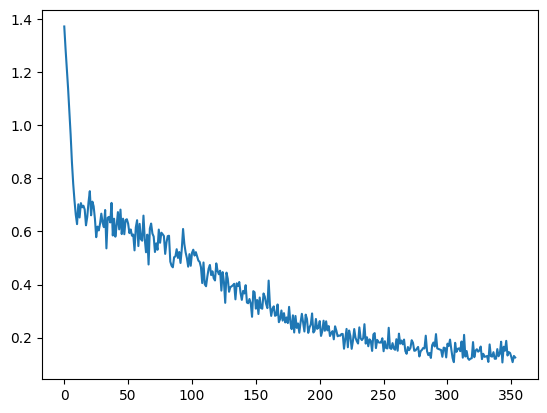

In [363]:
plt.plot(train_loss)
# train_loss

In [358]:
def select_grad(task, key):
    return [grad[key] for grad in task]

backbone.0.weight: 	0.0655 	0.2215
backbone.0.bias: 	0.1040 	0.0963
backbone.3.weight: 	0.0375 	0.0686
backbone.3.bias: 	0.3758 	0.0156
backbone.6.weight: 	0.0095 	0.0165
backbone.6.bias: 	0.0235 	0.0127


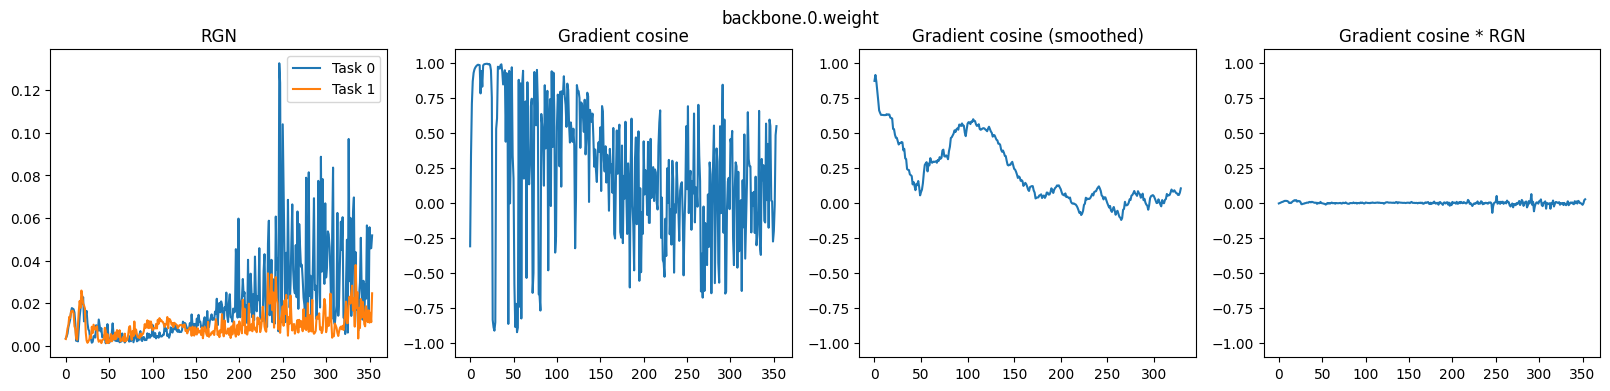

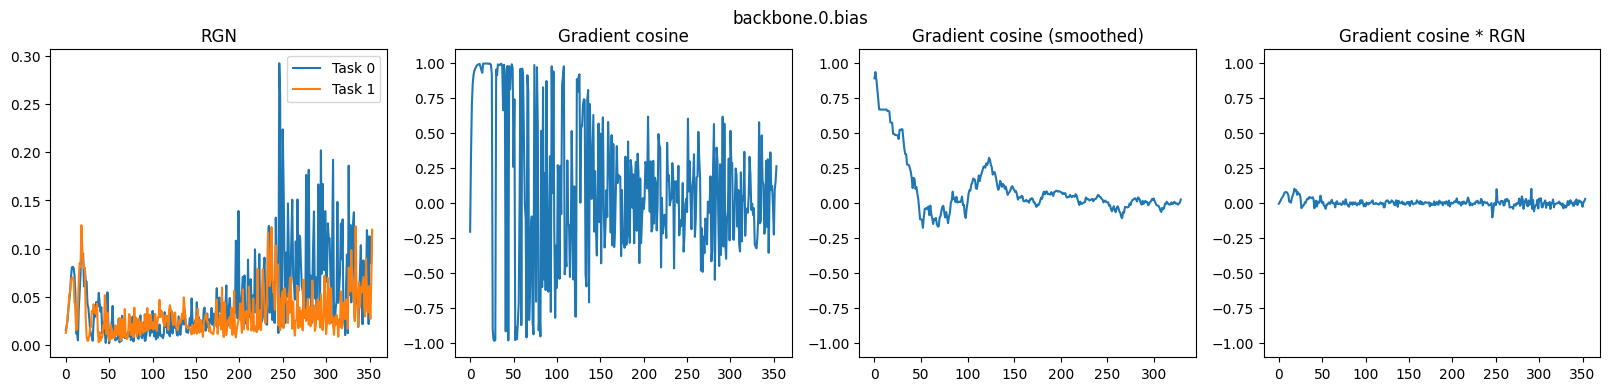

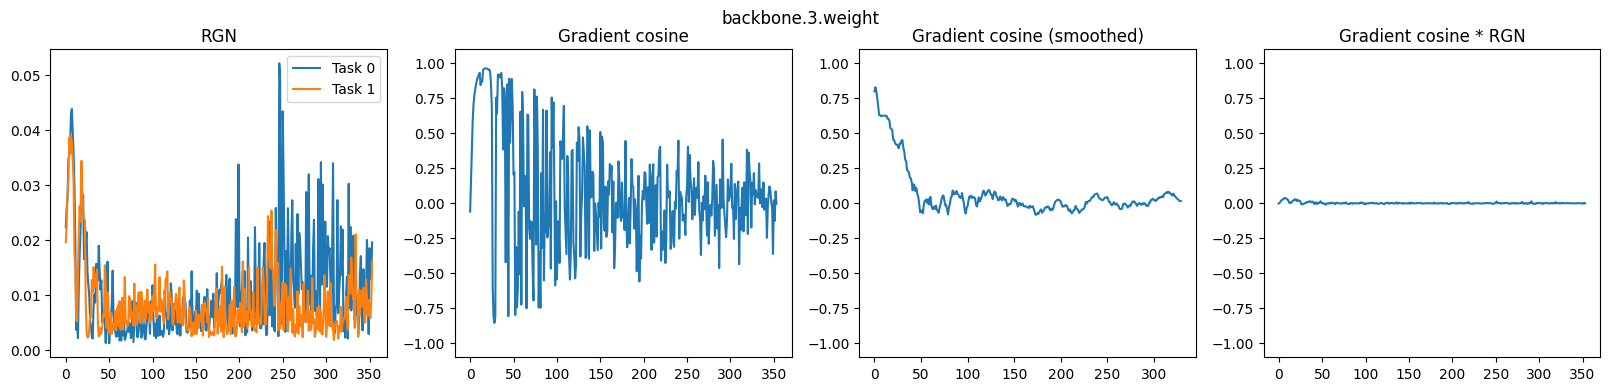

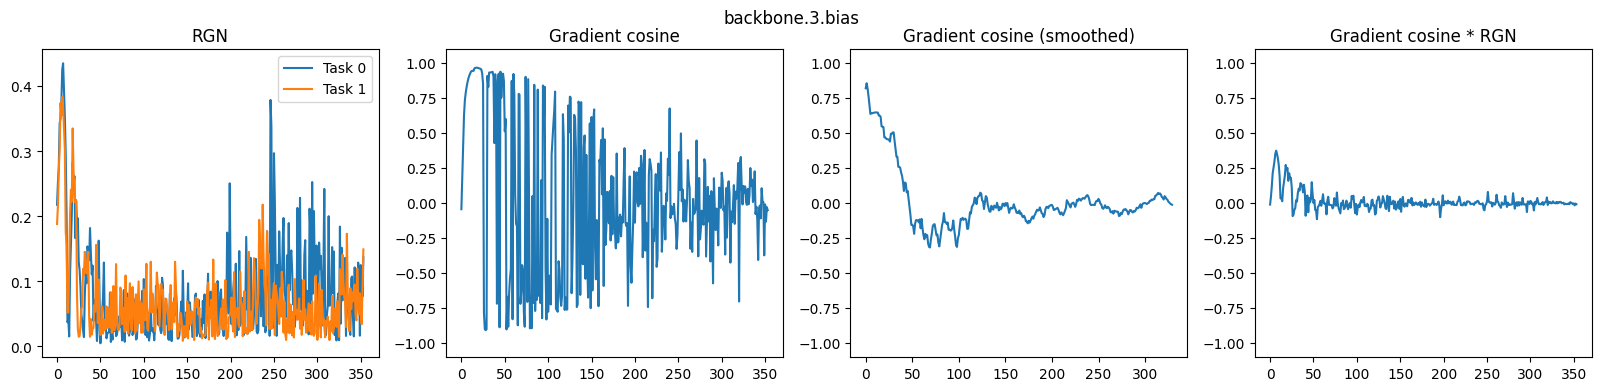

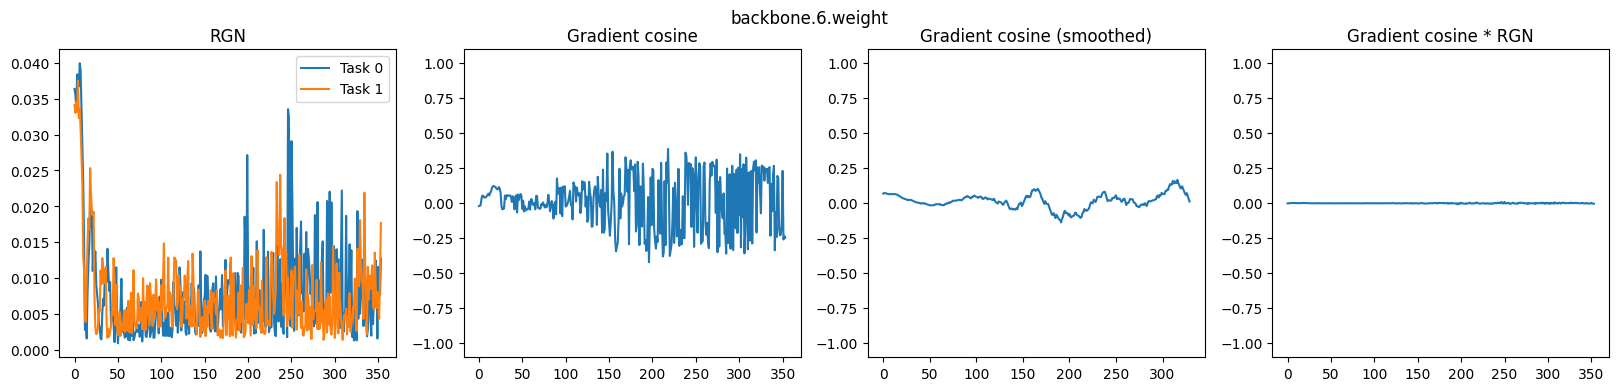

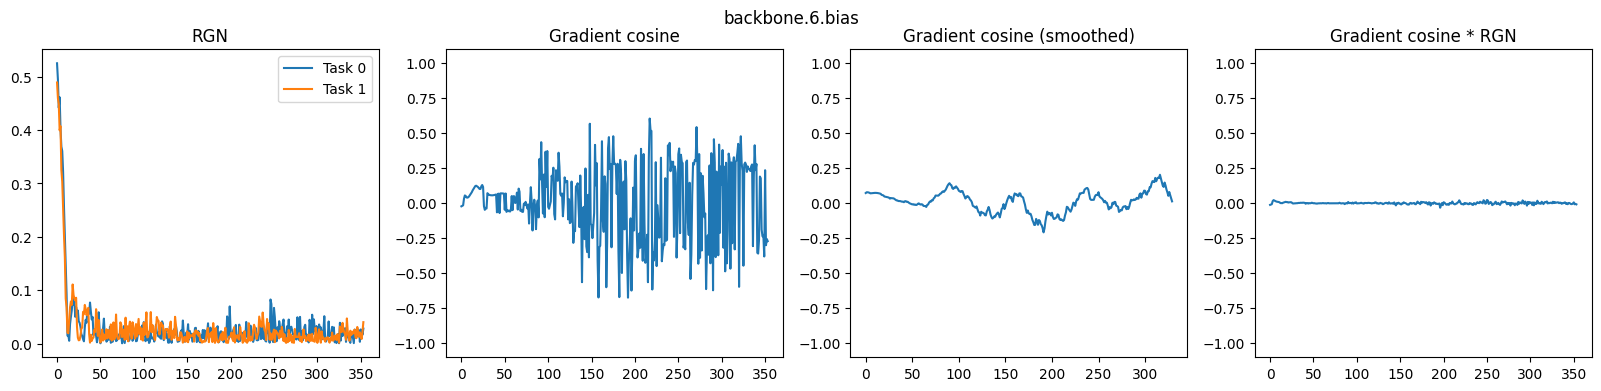

In [359]:
keys = list(mtl.state_dict().keys())
# print(keys)

for idx in range(len(keys)):
    g0 = select_grad(gradients['t0'], keys[idx])
    if g0[0] == None: continue
    g0 = torch.stack(g0)
    g0 = g0.view(g0.shape[0], -1)

    g1 = select_grad(gradients['t1'], keys[idx])
    if g1[0] == None: continue
    g1 = torch.stack(g1)
    g1 = g1.view(g1.shape[0], -1)

    # for rgn
    p = mtl.state_dict()[keys[idx]]
    p_norm = p.norm()

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(keys[idx])
    ax0 = axes[0]
    ax0.set_title('RGN')
    ax0.plot(g0.norm(dim=-1) / p_norm, label='Task 0')
    ax0.plot(g1.norm(dim=-1) / p_norm, label='Task 1')
    ax0.legend()

    sim = torch.sum(F.normalize(g0, dim=-1) * F.normalize(g1, dim=-1), dim=-1)
    # print(sim.min(), sim.max(), sim.mean(), sim.var())
    ax1 = axes[1]
    ax1.set_ylim([-1.1, 1.1])
    ax1.set_title('Gradient cosine')
    ax1.plot(sim)

    filter_size = 25
    x_smooth = F.conv1d(sim[None], torch.ones(1, 1, filter_size) / filter_size)
    ax2 = axes[2]
    ax2.set_ylim([-1.1, 1.1])
    ax2.set_title('Gradient cosine (smoothed)')
    ax2.plot(x_smooth[0])
    
    ax3 = axes[3]
    ax3.set_ylim([-1.1, 1.1])
    ax3.set_title('Gradient cosine * RGN')
    h = sim * g0.norm(dim=-1) / p_norm
    ax3.plot(h)
    print(f'{keys[idx]}: \t{h.max().item():.4f} \t{x_smooth.mean().item():.4f}')

In [373]:
def select_separate_grad(task_name, key):
    grads = gradients[task_name]
    return [grad[f'{task_name}_{key}'] for grad in grads]

backbone.3.weight: 	0.0170 	0.0166
head.bias: 	47.2633 	0.1239
backbone.6.bias: 	0.1657 	0.0156
backbone.3.bias: 	0.2930 	0.0295
backbone.0.bias: 	0.0612 	0.0673
head.weight: 	0.3285 	0.0472
backbone.0.weight: 	0.0140 	0.0545
backbone.6.weight: 	0.0064 	0.0047


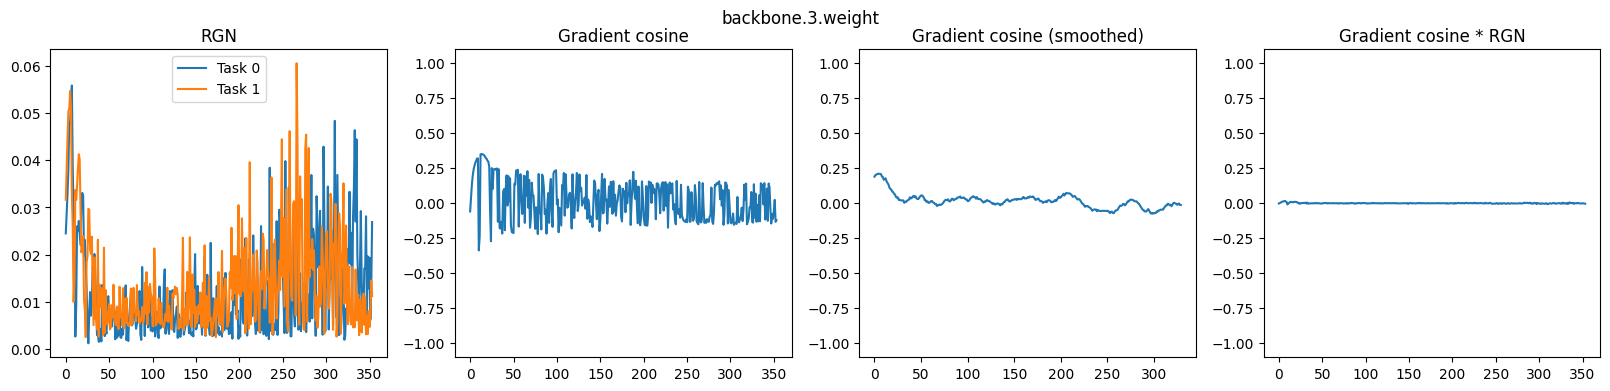

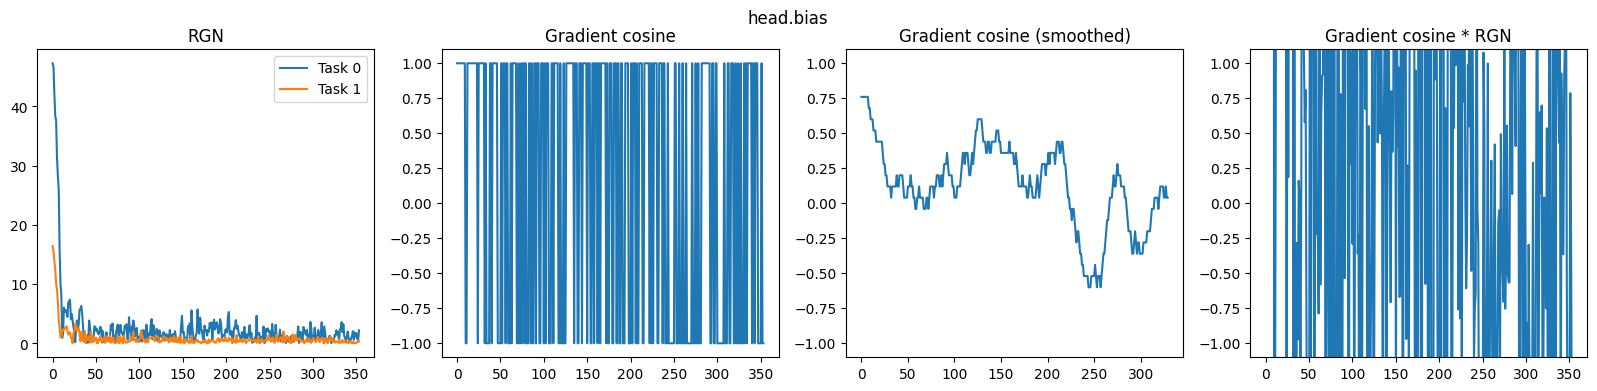

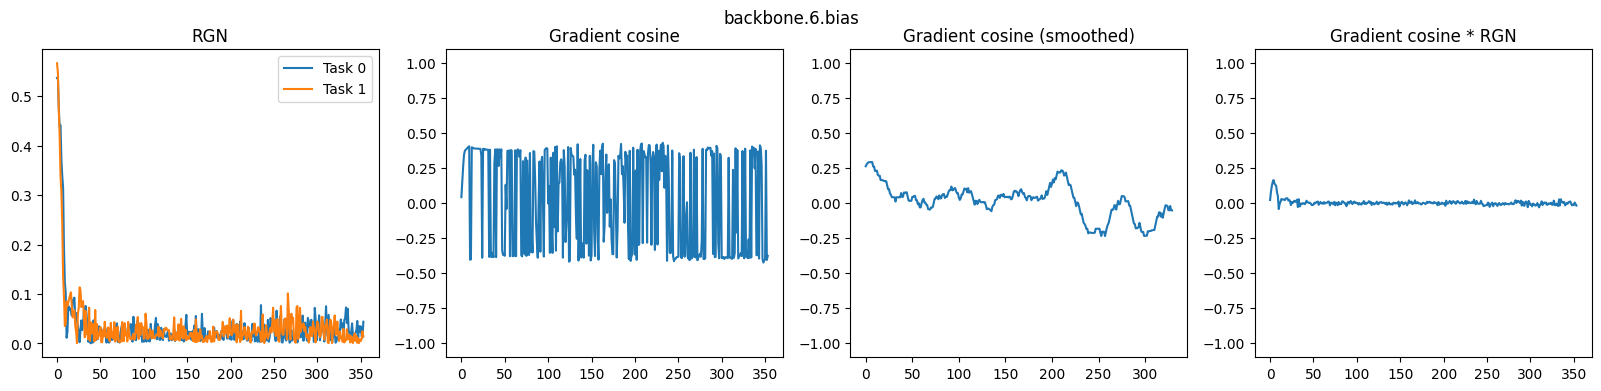

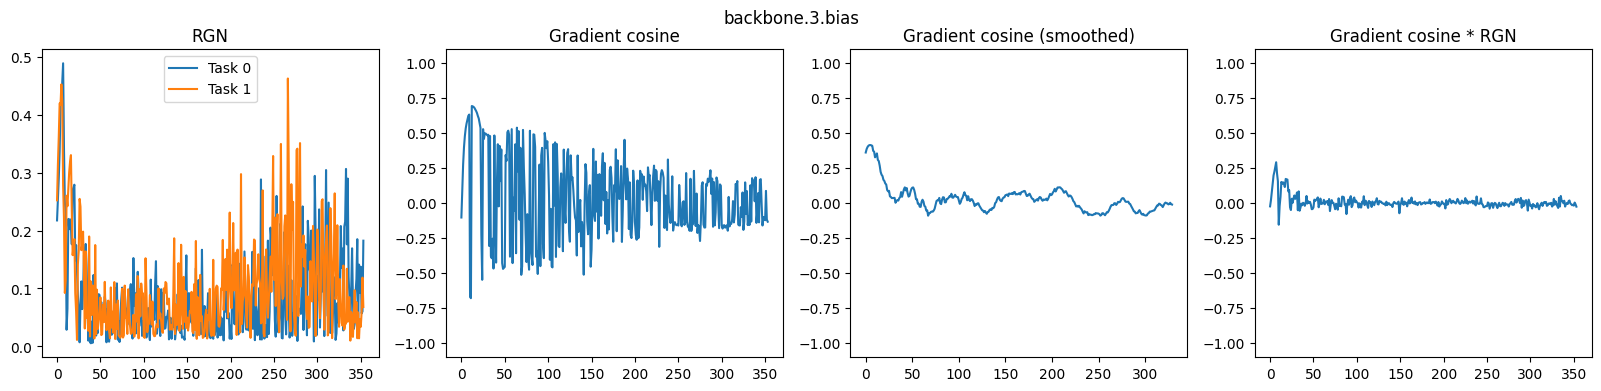

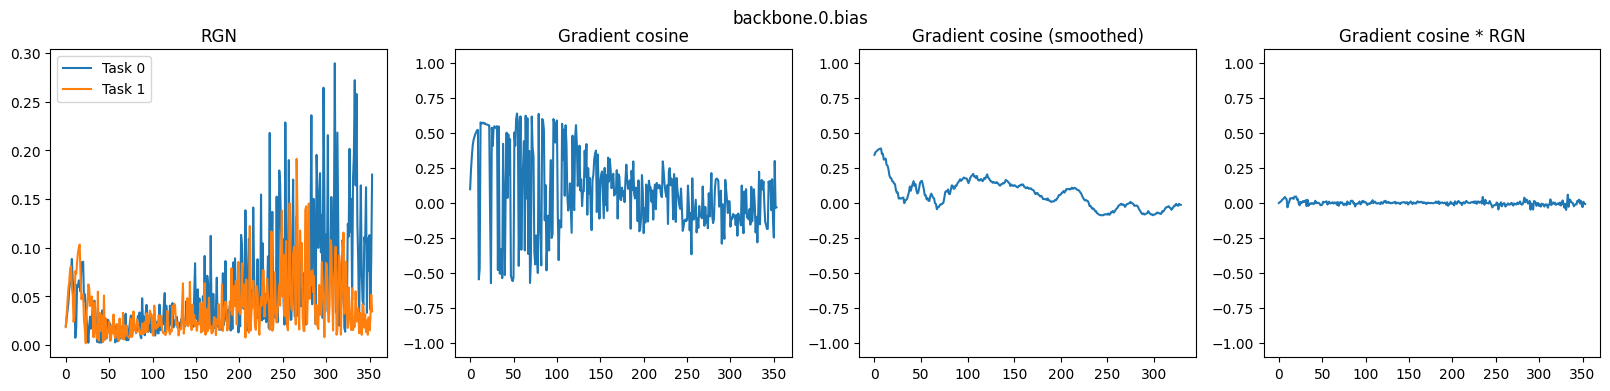

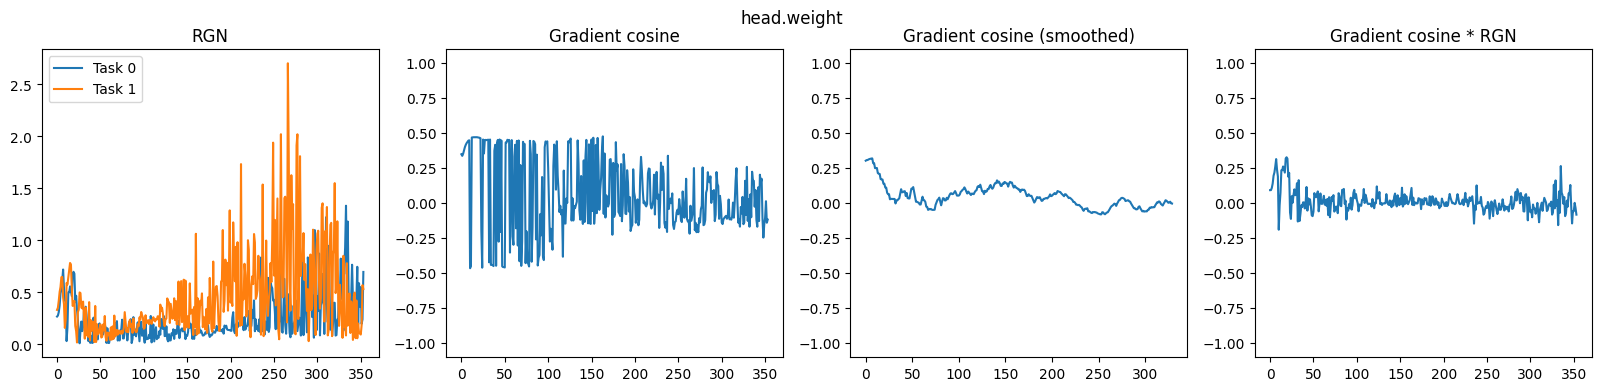

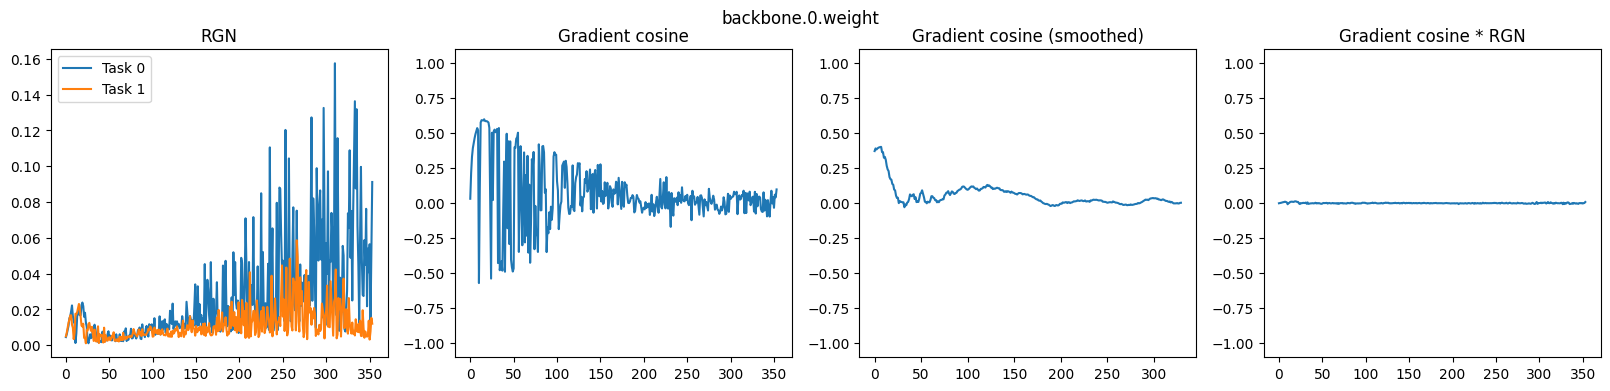

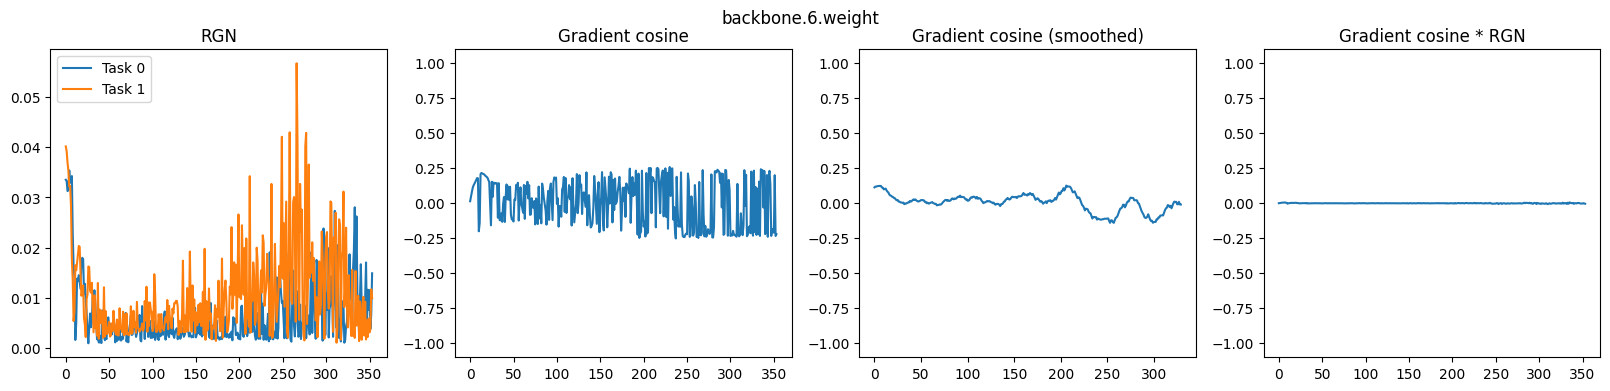

In [376]:
# keys = list(mtl.state_dict().keys())
# print(keys)
keys = list(set([k.split('_')[-1] for k in mtl.state_dict().keys()]))

for idx in range(len(keys)):
    g0 = select_separate_grad('t0', keys[idx])
    if g0[0] == None: continue
    g0 = torch.stack(g0)
    g0 = g0.view(g0.shape[0], -1)

    g1 = select_separate_grad('t1', keys[idx])
    if g1[0] == None: continue
    g1 = torch.stack(g1)
    g1 = g1.view(g1.shape[0], -1)

    # for rgn
    p = mtl.state_dict()['t0_'+keys[idx]]
    t0_norm = p.norm()

    p = mtl.state_dict()['t1_'+keys[idx]]
    t1_norm = p.norm()

    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(keys[idx])
    ax0 = axes[0]
    ax0.set_title('RGN')
    ax0.plot(g0.norm(dim=-1) / t0_norm, label='Task 0')
    ax0.plot(g1.norm(dim=-1) / t1_norm, label='Task 1')
    ax0.legend()

    sim = torch.sum(F.normalize(g0, dim=-1) * F.normalize(g1, dim=-1), dim=-1)
    # print(sim.min(), sim.max(), sim.mean(), sim.var())
    ax1 = axes[1]
    ax1.set_ylim([-1.1, 1.1])
    ax1.set_title('Gradient cosine')
    ax1.plot(sim)

    filter_size = 25
    x_smooth = F.conv1d(sim[None], torch.ones(1, 1, filter_size) / filter_size)
    ax2 = axes[2]
    ax2.set_ylim([-1.1, 1.1])
    ax2.set_title('Gradient cosine (smoothed)')
    ax2.plot(x_smooth[0])
    
    ax3 = axes[3]
    ax3.set_ylim([-1.1, 1.1])
    ax3.set_title('Gradient cosine * RGN')
    h = sim * g0.norm(dim=-1) / t0_norm
    ax3.plot(h)
    print(f'{keys[idx]}: \t{h.max().item():.4f} \t{x_smooth.mean().item():.4f}')

In [183]:
import copy
from torch import nn
import torch


class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
        )
    
    def forward(self, x):
        return self.net(x)


class Shareable(nn.Module):
    """Surgical parameter sharing module.
    
    This is the result of some *very* hacky engineering.
    Attempts to keep the compute graphs of each module identical while
    modifying the weight structures.
    """
    
    def __init__(self, mdl, task_keys, shared_params=[]):
        super().__init__()
        assert isinstance(task_keys, list)
        assert isinstance(shared_params, list)
        
        base_module_parameters = mdl.state_dict()
        
        k2s = {sp: '_'.join(sp.split('.')) for i, sp in enumerate(shared_params)}
        
        self.shared = nn.ParameterDict({
            k2s[sp]: nn.Parameter(base_module_parameters[sp].clone())
            for sp in shared_params
        })
    
        self.task_mdls = nn.ModuleDict({
            task_key: copy.deepcopy(mdl)
            for task_key in task_keys
        })
        
        for sp in shared_params:
            parameter = self.shared[k2s[sp]]
            for task_key in task_keys:
                self._override_parameter(self.task_mdls[task_key], sp, parameter)
            

    def _override_parameter(self, mdl, key, param):
        # TODO: this entire method is very sus

        assert isinstance(param, nn.Parameter), 'Must be a parameter'
        
        comps = key.split('.')
        ref = mdl
        while len(comps) > 1:
            comp = comps.pop(0)
            if comp in ref._modules:
                ref = ref._modules[comp]
            elif comp in ref._parameters:
                ref = ref._parameters[comp]
            else:
                raise ValueError('tree traversal failed')
            
        parameter_name = comps.pop()
        assert len(comps) == 0
        del ref._parameters[parameter_name]
        ref._parameters[parameter_name] = param

                       
    def forward(self, x, task_key):
        return self.task_mdls[task_key](x)

In [196]:
class LinearBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28 * 28, 32),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.net(x)

In [197]:
s = Shareable(LinearBackbone(), ['t0', 't1'], ['net.0.weight'])
s(torch.ones(1, 28 * 28), 't0').shape

torch.Size([1, 32])

In [214]:
class SurgicalMTL(nn.Module):    
    def __init__(self):
        super().__init__()
        self.s = Shareable(LinearBackbone(), ['t0', 't1'], ['net.0.weight'])
        self.heads = nn.ModuleDict({
            't0': nn.Linear(32, 1),
            't1': nn.Linear(32, 1),
        })
    
    def forward(self, x, task_key):
        return self.heads[task_key](self.s(x, task_key))

In [215]:
mtl = SurgicalMTL()
# optim = torch.optim.Adam(mtl.parameters(), 

In [216]:
len(list(mtl.named_parameters()))

7